In [1]:
import os
import re
import zipfile

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from PIL import Image
import ast
import json
from glob import glob
import cv2
import time

In [112]:
import tensorflow as tf

from tensorflow.keras import datasets, layers, models

INFO:tensorflow:Using local port 23564
INFO:tensorflow:Using local port 18095
INFO:tensorflow:Using local port 15289
INFO:tensorflow:Using local port 22792
INFO:tensorflow:Using local port 17775
INFO:tensorflow:Using local port 22194
INFO:tensorflow:Using local port 24929
INFO:tensorflow:Using local port 19755
INFO:tensorflow:Using local port 23958
INFO:tensorflow:Using local port 15346


- video 75
- annotation csv 75

In [204]:
forder_pedestrian = '/media/mvlab/46FA9CA2FA9C8FB3/dataset/tracking/P-DESTRE/'
forder_pedestrian_annotation = forder_pedestrian + 'annotation/'
forder_pedestrian_video = forder_pedestrian + 'videos/'
forder_pedestrian_images = forder_pedestrian + 'images/'
img_w = 128
img_h = 256
class_k = 261
path_weight = 'cnn_0.ckpt'

In [3]:
os.path.isdir(forder_pedestrian),os.path.isdir(forder_pedestrian_annotation),os.path.isdir(forder_pedestrian_video)

(True, True, True)

In [4]:
list_annotation_path = glob(forder_pedestrian_annotation + '*.txt')
list_video_path = glob(forder_pedestrian_video + '*.MP4')

In [5]:
list_annotation_path.sort()
list_video_path.sort()

In [6]:
len(list_annotation_path), len(list_video_path)

(75, 75)

In [7]:
columns = ['frame', 'ID', 'x', 'y', 'w', 'h', 'head', 'yaw', 'pitch', 'roll',          
          'gender', 'age', 'height', 'body volume', 'ethnicity', 'hair color', 'hairstyle', 'beard', 'mustache', 'glasses', 
           'head accessories', 'upper cloth', 'lower cloth', 'feet', 'accessories', 'action']
len(columns)

26

In [69]:
column_feature_index = 6

In [277]:
INDEX_ID = 0
INDEX_GENDER = 5
INDEX_AGE = 6
INDEX_HEIGHT = 7
INDEX_BODY_VOLUME = 8
INDEX_ETHNICITY = 9
INDEX_HAIR_COLOR = 10
INDEX_HAIRSTYLE = 11
INDEX_BEARD = 12

In [236]:
columns[column_feature_index:]

['head',
 'yaw',
 'pitch',
 'roll',
 'gender',
 'age',
 'height',
 'body volume',
 'ethnicity',
 'hair color',
 'hairstyle',
 'beard',
 'mustache',
 'glasses',
 'head accessories',
 'upper cloth',
 'lower cloth',
 'feet',
 'accessories',
 'action']

In [8]:
anntation_path = list_annotation_path[0]
video_path = list_video_path[0]
df = pd.read_csv(anntation_path, header=None, names=columns)
anntation_path, video_path, df.shape

('/media/mvlab/46FA9CA2FA9C8FB3/dataset/tracking/P-DESTRE/annotation/08-11-2019-1-1.txt',
 '/media/mvlab/46FA9CA2FA9C8FB3/dataset/tracking/P-DESTRE/videos/08-11-2019-1-1.MP4',
 (12564, 26))

In [9]:
df.head()

,frame,ID,x,y,w,h,head,yaw,pitch,roll,...,hairstyle,beard,mustache,glasses,head accessories,upper cloth,lower cloth,feet,accessories,action
0,3,-1,2071.6,975.06,96.16,221.94,-1,-1.000,-1.000,-1.000,...,1,1,0,0,3,8,2,0,6,0
1,3,205,1806.0,956.88,81.97,250.24,1,2.295,-32.574,-11.471,...,1,0,0,2,3,8,0,0,1,0
2,3,180,1904.5,967.00,87.08,245.00,1,2.295,-32.574,-11.471,...,1,0,0,2,3,8,0,4,1,0
3,3,-1,1775.4,941.00,54.12,222.00,-1,-1.000,-1.000,-1.000,...,1,1,1,2,3,8,2,4,6,0
4,4,-1,2071.3,975.19,96.17,221.81,-1,-1.000,-1.000,-1.000,...,1,1,0,0,3,8,2,0,6,0


In [10]:
df.tail()

,frame,ID,x,y,w,h,head,yaw,pitch,roll,...,hairstyle,beard,mustache,glasses,head accessories,upper cloth,lower cloth,feet,accessories,action
12559,1325,208,3309.0,1122.2,112.91,318.72,1,2.295,-32.574,-11.471,...,1,0,0,0,3,8,0,0,1,0
12560,1326,188,3046.7,2084.1,68.49,76.92,1,2.295,-32.574,-11.471,...,4,1,1,2,3,1,1,4,1,0
12561,1326,208,3399.0,1133.2,116.73,324.93,1,2.295,-32.574,-11.471,...,1,0,0,0,3,8,0,0,1,0
12562,1327,188,3114.8,2101.1,53.67,60.26,1,2.295,-32.574,-11.471,...,4,1,1,2,3,1,1,4,1,0
12563,1327,208,3490.0,1141.7,120.11,329.82,1,2.295,-32.574,-11.471,...,1,0,0,0,3,8,0,0,1,0


In [11]:
df[df['ID']==205]

,frame,ID,x,y,w,h,head,yaw,pitch,roll,...,hairstyle,beard,mustache,glasses,head accessories,upper cloth,lower cloth,feet,accessories,action
1,3,205,1806.0,956.88,81.97,250.24,1,2.295,-32.574,-11.471,...,1,0,0,2,3,8,0,0,1,0
5,4,205,1807.6,958.91,81.73,249.19,1,2.295,-32.574,-11.471,...,1,0,0,2,3,8,0,0,1,0
9,5,205,1806.3,959.67,82.40,251.61,1,2.295,-32.574,-11.471,...,1,0,0,2,3,8,0,0,1,0
13,6,205,1807.8,962.07,81.66,250.23,1,2.295,-32.574,-11.471,...,1,0,0,2,3,8,0,0,1,0
17,7,205,1806.6,960.81,82.03,251.75,1,2.295,-32.574,-11.471,...,1,0,0,2,3,8,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2120,299,205,1542.2,1928.50,193.53,228.48,1,2.295,-32.574,-11.471,...,1,0,0,2,3,8,0,0,1,0
2130,300,205,1542.1,1930.20,194.32,226.81,1,2.295,-32.574,-11.471,...,1,0,0,2,3,8,0,0,1,0
2140,301,205,1542.3,1933.20,193.41,223.79,1,2.295,-32.574,-11.471,...,1,0,0,2,3,8,0,0,1,0
2150,302,205,1543.4,1938.70,188.99,215.53,1,2.295,-32.574,-11.471,...,1,0,0,2,3,8,0,0,1,0


In [12]:
df.isna().sum().sum()

0

In [13]:
len(df)/df['frame'].nunique()

9.482264150943395

In [14]:
df.nunique()

frame                1325
ID                     35
x                    6956
y                    7371
w                    8400
h                   10584
head                    2
yaw                     2
pitch                   2
roll                    2
gender                  2
age                     3
height                  2
body volume             2
ethnicity               1
hair color              1
hairstyle               4
beard                   2
mustache                2
glasses                 2
head accessories        1
upper cloth             5
lower cloth             4
feet                    3
accessories             4
action                  2
dtype: int64

In [241]:
feature_column_k = [class_k, 2, 1, 1, 1, 2, 9, 5, 4, 5, 7, 6, 3, 3, 4, 5, 12, 10, 7, 8, 14]
len(feature_column_k), len(columns[column_feature_index:])

(21, 20)

In [15]:
df['gender'].unique(), df['age'].unique(), df['height'].unique(), df['body volume'].unique()

(array([0, 1]), array([4, 2, 3]), array([2, 1]), array([0, 1]))

In [16]:
df['hairstyle'].unique(), df['beard'].unique(), df['mustache'].unique(), df['glasses'].unique()

(array([1, 4, 3, 2]), array([1, 0]), array([0, 1]), array([0, 2]))

In [17]:
df['head accessories'].unique(), df['action'].unique(), df['accessories'].unique()

(array([3]), array([0, 2]), array([6, 1, 0, 2]))

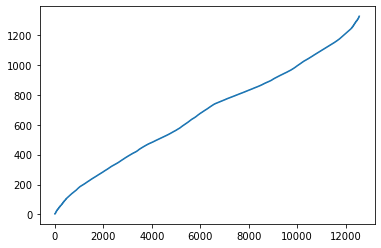

In [18]:
ax = df['frame'].plot()

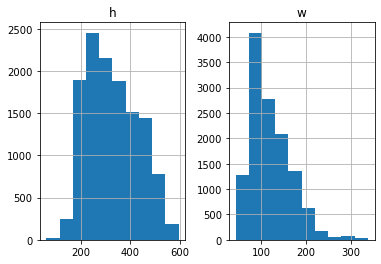

In [19]:
ax = df[['w', 'h']].hist()

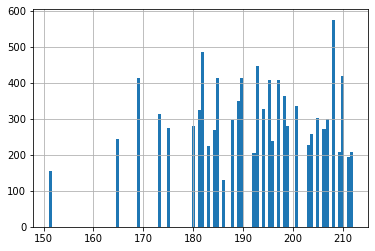

In [20]:
ax = df['ID'][df['ID']>0].hist(bins=100)

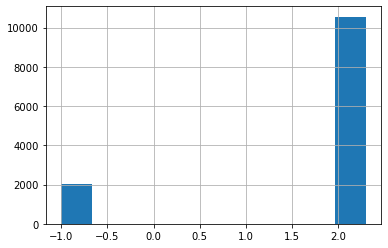

In [21]:
ax = df['yaw'].hist()

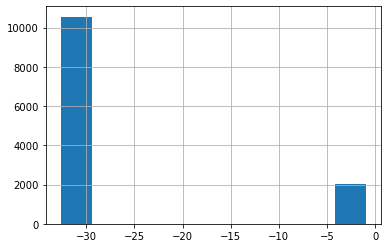

In [22]:
ax = df['pitch'].hist()

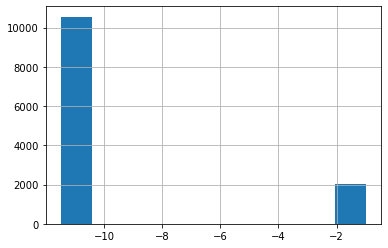

In [23]:
ax = df['roll'].hist()

In [24]:
df['frame'].value_counts()

793     16
778     16
786     16
794     16
802     16
        ..
17       3
9        3
1325     2
1326     2
1327     2
Name: frame, Length: 1325, dtype: int64

In [25]:
def video_to_frames(input_loc, output_loc):
    """Function to extract frames from input video file
    and save them as separate frames in an output directory.
    Args:
        input_loc: Input video file.
        output_loc: Output directory to save the frames.
    Returns:
        None
    """
    try:
        os.mkdir(output_loc)
    except OSError:
        pass
    # Log the time
    time_start = time.time()
    # Start capturing the feed
    cap = cv2.VideoCapture(input_loc)
    # Find the number of frames
    video_length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT)) - 1
    print ("Number of frames: ", video_length)
    count = 0
    print ("Converting video..\n")
    # Start converting the video
    while cap.isOpened():
        # Extract the frame
        ret, frame = cap.read()
        # Write the results back to output location.
        cv2.imwrite(output_loc + "/%#05d.jpg" % (count+1), frame)
        count = count + 1
        # If there are no more frames left
        if count % 100==0:
            print('count', video_length, count)
        if (count > (video_length-1)):
            # Log the time again
            time_end = time.time()
            # Release the feed
            cap.release()
            # Print stats
            print ("Done extracting frames.\n%d frames extracted" % count)
            print ("It took %d seconds forconversion." % (time_end-time_start))
            break


In [26]:
input_loc = video_path
file_name = input_loc.split(os.sep)[-1]

file_name

'08-11-2019-1-1.MP4'

In [27]:
input_loc = video_path
output_loc = forder_pedestrian_images + file_name

video_to_frames(input_loc, output_loc)

In [28]:
def visualize_detections(image_path, annotation, is_save, figsize=(18, 18), linewidth=1, color=[0, 0, 1]):
    """Visualize Detections"""
    image = Image.open(image_path)
    image = np.array(image, dtype=np.uint8)
    img_h, img_w, img_c = image.shape
    plt.figure(figsize=figsize)
    plt.axis("off")
    plt.imshow(image)
    ax = plt.gca()
    x = annotation[:, 2]
    y = annotation[:, 3]
    w = annotation[:, 4]
    h = annotation[:, 5]
    boxes = np.stack((x, y, x+w, y+h), -1)
    classes = annotation[:, 1]
    features = annotation[:, 7:].astype(np.int)
    title = str.format('(%dx%d) %d box' %(img_h, img_w, len(boxes)))
    if len(boxes)>0:
        boxes_width = boxes[:, 2] - boxes[:, 0]
        boxes_height = boxes[:, 3] - boxes[:, 1]
        box_min_width = np.min(boxes_width)
        box_max_width = np.max(boxes_width)
        title = str.format('(%dx%d) %d box, width:%d ~ %d' 
                           %(img_h, img_w, len(boxes), box_min_width, box_max_width))

        for box, cls, feature in zip(boxes, classes, features):
            x1, y1, x2, y2 = box        
            w, h = x2 - x1, y2 - y1
            color = [0,1,0]
            patch = plt.Rectangle(
                [x1, y1], w, h, fill=False, edgecolor=color, linewidth=linewidth
            )
            ax.add_patch(patch)
            score_txt = int(cls) if cls > -1 else ''
            score_txt = str(score_txt)# + str(feature)
            ax.text(x1, y1, score_txt, bbox={"facecolor": [1,1,0], "alpha": 0.4}, clip_box=ax.clipbox, clip_on=True,)
    plt.title(title)
    if is_save:
        print('save', 'image_path', image_path)#save image_path 08-11-2019-1-1.MP4/00303.jpg
        path_subfolder = image_path.split(os.sep)[-2]
        path_filename = image_path.split(os.sep)[-1]
        path_save_folder = 'debug/'#+path_subfolder
        if not os.path.isdir(path_save_folder):
            os.mkdir(path_save_folder)
        
        plt.savefig(path_save_folder+ os.sep +path_subfolder +'_'+ path_filename, bbox_inches='tight')    
    #else: plt.show()
    return ax

for i in range(10000):
    ax = visualize_frame(i, is_save=True)

In [29]:
def crop_object(image_path, annotation):
    """Visualize Detections"""
    image = Image.open(image_path)
    arr = np.array(image, dtype=np.uint8)
    img_h, img_w, img_c = arr.shape
    
    list_x = []
    list_y = []
        
    for i in range(len(annotation)):
        annot = annotation[i]                
        x = int(annot[2])
        y = int(annot[3])
        w = int(annot[4])
        h = int(annot[5])
        
        arr_obj = arr[y:y+h, x:x+w]
        list_x.append(arr_obj)
        list_y.append(annot)
        
    return list_x, list_y

In [90]:
def crop_person_by_id(path_img, max_m=1e+10, cut_h=256, cut_w=128):
    
    person_arrs = []
    person_labels = []
    
    video_file_name = path_img.split('/')[-1]
    video_file_name_pre = video_file_name.split('.')[0]
    path_label = forder_pedestrian_annotation + video_file_name_pre + '.txt'
    #print('video_file_name', video_file_name)
    #print('label exist', os.path.isfile(path_label), path_label)
    df_video = pd.read_csv(path_label, header=None, names=columns)
    cond = df_video['ID'] > -1    
    df_video_valid = df_video[cond]
    print('df_video_valid', len(df_video), len(df_video_valid)), 
    path_images = forder_pedestrian_images + video_file_name + os.sep  
    list_imgs = glob(path_images + '*')
    list_imgs.sort()
    
    frame_min = df_video_valid['frame'].min()
    frame_max = df_video_valid['frame'].max()    
    for frame in df_video_valid['frame'].unique():
        #df_row = list_imgs.iloc[i]
        df_frame = df_video_valid[df_video_valid['frame']==frame]
        path_img = list_imgs[frame]
        #print('path_img', frame, len(df_frame))
        img = Image.open(path_img)
        img_arr = np.array(img)
        for j in range(len(df_frame)):
            df_row = df_frame.iloc[j]
            person_id, x0, y0, w, h = df_row[['ID', 'x', 'y', 'w', 'h']]
            x1 = x0 + w
            y1 = y0 + h            
            img_person_crop = img.crop((x0, y0, x1, y1))
            img_person_crop = img_person_crop.resize((cut_w, cut_h))
            features = df_row.values[column_feature_index:].astype(np.int)
            
            person_arrs.append(np.array(img_person_crop))
            person_label = np.concatenate((np.reshape(person_id, [1]), features), 0)
            person_labels.append(person_label)
            #print(features)
            #print('df_frame', frame, len(df_frame), person_id)        
            if len(person_arrs) % 500==0: 
                print('len(person_arrs)', len(person_arrs))
            if len(person_arrs) >= max_m:
                break       
    
    person_arrs = np.stack(person_arrs)
    person_labels = np.stack(person_labels)
    print('len', len(person_arrs), len(person_labels), person_arrs.shape, person_labels.shape)
    print('nunique ID', len(np.unique(person_labels[:, 0])))
    return df_video, person_arrs, person_labels

In [168]:
df_video, person_arrs, person_labels = crop_person_by_id(output_loc, max_m=20000)

df_video_valid 12564 10555
len(person_arrs) 200
len(person_arrs) 800
len(person_arrs) 1600
len(person_arrs) 2600
len(person_arrs) 2700
len(person_arrs) 3700
len(person_arrs) 4100
len(person_arrs) 4400
len(person_arrs) 4600
len(person_arrs) 7500
len(person_arrs) 8500
len(person_arrs) 8700
len 10555 10555 (10555, 256, 128, 3) (10555, 21)
nunique ID 34


In [173]:
person_labels[:, 0]

array([205., 180., 205., ..., 208., 188., 208.])

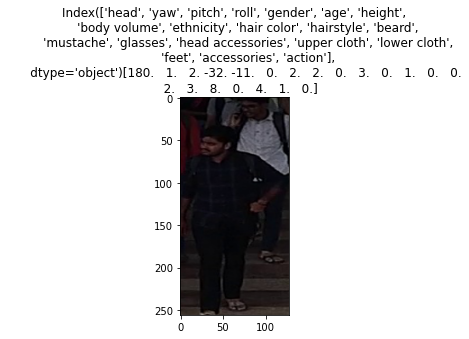

In [174]:
i = 100
plt.title(str(df.columns[column_feature_index:]) + str(person_labels[i]))
plt.imshow(person_arrs[i])

/home/mvlab/anaconda3/lib/python3.8/site-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


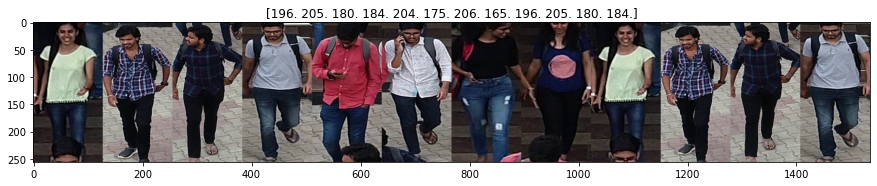

In [283]:
plt.figure(figsize=(15,10))
plt.title(person_labels[1000:1012, INDEX_ID])
plt.imshow(np.concatenate(person_arrs[1000:1012], axis=1))

In [202]:
x_train = person_arrs[::20]
y_train = person_labels[::20]
x_test = person_arrs[1::2]
y_test = person_labels[1::2]

In [203]:
len(x_train), len(x_test), x_train.shape, y_train.shape

(528, 5277, (528, 256, 128, 3), (528, 21))

In [182]:
len(np.unique(y_train)), len(np.unique(y_test)), np.unique(y_train) == np.unique(y_test)

(34,
 34,
 array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True]))

In [197]:
model = models.Sequential()
model.add(layers.Input((img_h, img_w, 3)))
model.add(layers.Conv2D(32, (7, 7), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.25))
model.add(layers.Dense(1000))

model.summary()

In [242]:
len(columns[column_feature_index:]), columns[column_feature_index:], feature_column_k

(20,
 ['head',
  'yaw',
  'pitch',
  'roll',
  'gender',
  'age',
  'height',
  'body volume',
  'ethnicity',
  'hair color',
  'hairstyle',
  'beard',
  'mustache',
  'glasses',
  'head accessories',
  'upper cloth',
  'lower cloth',
  'feet',
  'accessories',
  'action'],
 [261, 2, 1, 1, 1, 2, 9, 5, 4, 5, 7, 6, 3, 3, 4, 5, 12, 10, 7, 8, 14])

In [286]:
feature_column_k_cumsum = np.cumsum(feature_column_k)
feature_column_k, feature_column_k_cumsum

([261, 2, 1, 1, 1, 2, 9, 5, 4, 5, 7, 6, 3, 3, 4, 5, 12, 10, 7, 8, 14],
 array([261, 263, 264, 265, 266, 268, 277, 282, 286, 291, 298, 304, 307,
        310, 314, 319, 331, 341, 348, 356, 370]))

In [244]:
feature_column_k[4], feature_column_k[5]

(1, 2)

In [287]:
class NetLoss(tf.losses.Loss):
    
    def __init__(self):
        super(NetLoss, self).__init__(reduction="auto", name="NetLoss")        

    def call(self, y, h):
        y_cls = tf.cast(y[:, 0], tf.int64)
        y_gender = tf.cast(y[:, INDEX_GENDER], tf.int64)
        y_age = tf.cast(y[:, INDEX_AGE], tf.int64)        
        
        h_cls = h[:, :feature_column_k_cumsum[0]]
        h_gender = h[:, feature_column_k_cumsum[INDEX_GENDER-1]:feature_column_k_cumsum[INDEX_GENDER]]
        h_age = h[:, feature_column_k_cumsum[INDEX_AGE-1]:feature_column_k_cumsum[INDEX_AGE]]
        
        y_hot = tf.one_hot(y_cls, class_k)        
        pt = tf.nn.softmax(h_cls)
        pt = tf.clip_by_value(pt, 1e-7, 1.0 - 1e-7)                
        loss_p = - y_hot * tf.math.log(pt)        
        loss_f = - (1 - y_hot) * tf.math.log(1 - pt)
        loss = loss_p + loss_f
        
        loss_cls = tf.losses.sparse_categorical_crossentropy(y_cls, h_cls, from_logits=True)        
        loss_gender = tf.losses.sparse_categorical_crossentropy(y_gender, h_gender, from_logits=True)
        loss_age = tf.losses.sparse_categorical_crossentropy(y_age, h_age, from_logits=True)
        
        loss = loss_cls + loss_gender + loss_age
        
        return loss

In [288]:
def acc_cls(y, h):    
    y_cls = tf.cast(y[:, 0], tf.int64)
    h_score = h[:, :feature_column_k[0]]
    h_cls = tf.argmax(h_score, -1)    
    
    acc = tf.equal(y_cls, h_cls)
    return acc

def acc_gender(y, h):    
    y_cls = tf.cast(y[:, INDEX_GENDER], tf.int64)
    h_score = h[:, feature_column_k_cumsum[INDEX_GENDER-1]:feature_column_k_cumsum[INDEX_GENDER]]
    h_cls = tf.argmax(h_score, -1)
    acc = tf.equal(y_cls, h_cls)
    return acc

def acc_age(y, h):    
    y_cls = tf.cast(y[:, INDEX_AGE], tf.int64)
    h_score = h[:, feature_column_k_cumsum[INDEX_AGE-1]:feature_column_k_cumsum[INDEX_AGE]]
    h_cls = tf.argmax(h_score, -1)
    acc = tf.equal(y_cls, h_cls)
    return acc

In [289]:
loss_fn = NetLoss()
model.compile(optimizer='adam', loss=loss_fn, metrics=[acc_cls, acc_gender, acc_age])

In [290]:
model.load_weights(path_weight)

In [291]:
history = model.fit(x_train, y_train, epochs=20)

Epoch 1/20
17/17 [==============================] - 9s 511ms/step - loss: 4.1260 - acc_cls: 0.9131 - acc_gender: 0.5771 - acc_age: 0.7165
Epoch 2/20
17/17 [==============================] - 9s 523ms/step - loss: 0.7746 - acc_cls: 0.9836 - acc_gender: 0.8631 - acc_age: 0.9386
Epoch 3/20
17/17 [==============================] - 9s 516ms/step - loss: 0.3191 - acc_cls: 0.9891 - acc_gender: 0.9263 - acc_age: 0.9900
Epoch 4/20
17/17 [==============================] - 9s 519ms/step - loss: 0.0935 - acc_cls: 0.9957 - acc_gender: 0.9766 - acc_age: 0.9997
Epoch 5/20
17/17 [==============================] - 9s 520ms/step - loss: 0.1344 - acc_cls: 1.0000 - acc_gender: 0.9677 - acc_age: 0.9890
Epoch 6/20
17/17 [==============================] - 9s 516ms/step - loss: 0.0955 - acc_cls: 0.9988 - acc_gender: 0.9809 - acc_age: 0.9972
Epoch 7/20
17/17 [==============================] - 9s 520ms/step - loss: 0.0295 - acc_cls: 0.9992 - acc_gender: 0.9878 - acc_age: 0.9988
Epoch 8/20
17/17 [================

In [292]:
model.save_weights(path_weight)

In [293]:
model.evaluate(x_test, y_test)
'''
cls          : 75%
cls + gender : 70~78%
'''

165/165 [==============================] - 12s 70ms/step - loss: 2.6508 - acc_cls: 0.7745 - acc_gender: 0.9113 - acc_age: 0.9661


'\ncls          : 75%\ncls + gender : 70~78%\n'